In [ ]:
!unzip nlp_test_task_2022.zip

In [ ]:
!pip install lazypredict transformers tensorflow_text

In [ ]:
import pandas as pd

data = pd.read_table('dataset/train.tsv')

In [ ]:
from sklearn.metrics import log_loss, f1_score, roc_curve, auc
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
data.describe()

,is_fake
count,5758.000000
mean,0.500000
std,0.500043
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7febc6c57410>]],
      dtype=object)

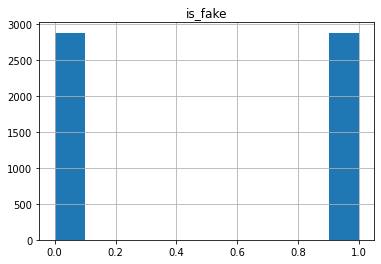

In [ ]:
data.hist()

**Data is balanced** - that's great. 

Imbalanced might significantly affect on performance.



---

Let's check the amount of russian words:

There are 50237 words and 8 per sentance in average


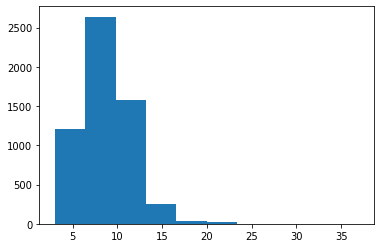

In [ ]:
from matplotlib import pyplot as plt

lens = [len(sent.split(' ')) for sent in data['title']]

plt.hist(lens)

print(f'There are {sum(lens)} words and {sum(lens)//len(data)} per sentance in average')

In [ ]:
import re

r = re.compile("[а-яА-Я]+")
data_russian = []
for sent in data['title']:
  words = sent.split(' ')
  words_russian = [word for word in filter(r.match, words)]
  data_russian.append(words_russian)

There are 47051 words and 8 per sentance in average


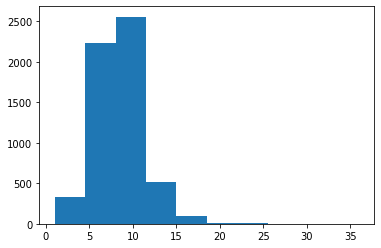

In [ ]:
from matplotlib import pyplot as plt
from lazypredict.Supervised import LazyClassifier
import numpy as np
import pandas as pd

lens_russian = [len(sent) for sent in data_russian]

plt.hist(lens_russian)

print(f'There are {sum(lens_russian)} words and {sum(lens_russian)//len(data)} per sentance in average')

In [ ]:
print(f'% of non-russian words is {100*(sum(lens)-sum(lens_russian))//sum(lens)} %')

% of non-russian words is 6 %


---
**Evaluation**



In [ ]:
def eval(y_true, y_pred):
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])

# **Pipeline**

Here we explore different options for classifiers for given dataset.
1. Embedding choice: LaBSE VS SBERT
2. Classifier: multiple general classifiers VS LSTM

Different representation functions are needed to find the best one. LaBSE and SBERT have Russian models. 
Also model Doc2Vec was considered but it is supposed to be for English (therefore it was decided to check this model)

Two types of classifiers are chosen because there is an assumption general classifiers are capable to learn how to distingush Real from Fake due to sufficient and informative representation model (=embeddings). LSTM is chosen to be compared with general classifiers to show that significant performance can be archived by lighter classifiers which are not computationally demanding.

In [ ]:
colnames_names = ['title', 'is_fake']
test_data = pd.read_table('dataset/test.tsv')

In [ ]:
test_data

,title,is_fake
0,Роскомнадзор представил реестр сочетаний цвето...,0
1,Ночью под Минском на президентской горе Белара...,0
2,Бывший спичрайтер Юрия Лозы рассказал о трудно...,0
3,"Сельская церковь, собравшая рекордно низкое ко...",0
4,Акции Google рухнули после объявления о переза...,0
...,...,...
995,Прокуратура заподозрила Явлинского в авторитар...,0
996,В День Победы стратегические ракетоносцы Ту-16...,0
997,СК возбудил дело против авиакомпании «Победа» ...,0
998,Криптомонетный двор Туркменистана выпустил юби...,0


In [ ]:
x_train = data.loc[:,'title']
y_train = data.loc[:,'is_fake']
x_test = test_data.loc[:,'title']
y_test = test_data.loc[:,'is_fake']

## **Model representation - LaBSE**

Different representation approaches is used, first of them is LaBSE.

In [ ]:
import time
from transformers import AutoTokenizer, AutoModel
import torch
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow_hub as hub
import tensorflow as tf
import tensorflow_text as text

def normalization(embeds):
  norms = np.linalg.norm(embeds, 2, axis=1, keepdims=True)
  return embeds/norms


preprocessor = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2")
encoder = hub.KerasLayer("https://tfhub.dev/google/LaBSE/2")

def sent_preprocess(sentence):
  return np.array(normalization(encoder(preprocessor(tf.constant([sentence])))["default"]))[0]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
import tqdm
import numpy as np

x_train_preprocessed = [sent_preprocess(sent) for sent in tqdm.tqdm(x_train)]
x_test_preprocessed = [sent_preprocess(sent) for sent in tqdm.tqdm(x_test)]

100%|██████████| 1000/1000 [10:10<00:00,  1.64it/s]


In [ ]:
## data is saved for optimization purposes - in order to save time calculating LaBse representation of data

x_train_preprocessed_labse = x_train_preprocessed
x_test_preprocessed_labse = x_test_preprocessed

In [ ]:
from lazypredict.Supervised import LazyClassifier
import numpy as np
import pandas as pd

size = np.array(x_train).shape[0]
vector_size = 768

In [ ]:
## Split into valid and train sets

x_valid_preprocessed = x_train_preprocessed[5001:size]
x_train_preprocessed = x_train_preprocessed[0:5000]

y_valid = y_train[5001:size]
y_train = y_train[0:5000]

print(len(x_valid_preprocessed))
print(len(x_train_preprocessed))
print(len(y_valid))
print(len(y_train))

757
5000
757
5000


### **General Classifiers**

There is an application of most popular and wide-spread classifiers for current representation

In [ ]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(np.array(x_train_preprocessed).reshape([len(x_train_preprocessed),vector_size]), np.array(x_valid_preprocessed).reshape([len(x_valid_preprocessed),vector_size]), y_train, y_valid)

print(models)

100%|██████████| 29/29 [05:01<00:00, 10.40s/it]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
SVC                                0.90               0.90     0.90      0.90   
NuSVC                              0.89               0.89     0.89      0.89   
RidgeClassifierCV                  0.88               0.88     0.88      0.88   
LGBMClassifier                     0.88               0.88     0.88      0.88   
RidgeClassifier                    0.87               0.87     0.87      0.87   
LinearDiscriminantAnalysis         0.87               0.87     0.87      0.87   
XGBClassifier                      0.87               0.87     0.87      0.87   
LogisticRegression                 0.87               0.87     0.87      0.87   
SGDClassifier                      0.87               0.87     0.87      0.87   
QuadraticDiscriminantAnalysis      0.85               0.85     0.85      0.85   
Perceptron                  

Models are performed well, but **SVC** performed better

In [ ]:
models = clf.provide_models(np.array(x_train_preprocessed).reshape([len(x_train_preprocessed),vector_size]), np.array(x_valid_preprocessed).reshape([len(x_valid_preprocessed),vector_size]), y_train, y_valid)
predictions = models['SVC'].predict(np.array(x_valid_preprocessed).reshape([len(x_valid_preprocessed),vector_size]))

print(sum([predictions[i] == np.array(y_valid)[i] for i in range(len(x_valid_preprocessed))]), len(x_valid_preprocessed))

679 757


LaBSE, best general classifier
F-measure or f1-score:  0.8984374999999999
AUC:  0.8972490779032078
Classification Report:
              precision    recall  f1-score   support

           1     0.9103    0.8869    0.8984       389
           0     0.8836    0.9076    0.8954       368

    accuracy                         0.8970       757
   macro avg     0.8969    0.8972    0.8969       757
weighted avg     0.8973    0.8970    0.8970       757



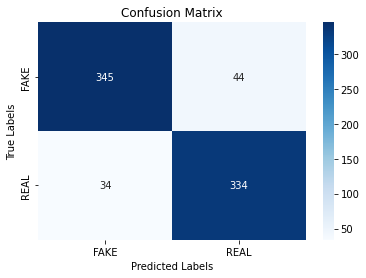

In [ ]:
# model evaluation
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
import seaborn as sns

print("LaBSE, best general classifier")
print("F-measure or f1-score: ", f1_score(y_valid, predictions))
# print("Log loss: ", log_loss(y_test, predictions))

fpr, tpr, thresholds = roc_curve(y_valid, predictions)

print("AUC: ", auc(fpr, tpr))

eval(y_valid, predictions)

### **LSTM classifier**

In [ ]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from matplotlib import pyplot
from keras.layers import Bidirectional

In [ ]:
lstm = Sequential()
lstm.add(Bidirectional(LSTM(768, return_sequences=False)))
lstm.add(Dense(1, activation='sigmoid'))

callback = EarlyStopping(monitor='val_loss', patience=7)

lstm.compile(loss='binary_crossentropy', optimizer='adam')
lstm.fit(np.array(x_train_preprocessed).reshape([len(x_train_preprocessed),1,vector_size]), y_train, validation_data=(np.array(x_valid_preprocessed).reshape([len(x_valid_preprocessed),1,vector_size]), y_valid), epochs=50, batch_size=128, verbose=1, shuffle=True, callbacks=[callback])


Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


  0%|          | 0/5758 [1:25:33<?, ?it/s]


40/40 [==============================] - ETA: 0s - loss: 0.5280WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f164ccb7e60> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
40/40 [==============================] - 16s 239ms/step - loss: 0.5280 - val_loss: 0.3620
Epoch 2/50
40/40 [==============================] - 8s 202ms/step - loss: 0.3219 - val_loss: 0.3039
Epoch 3/50
40/40 [==============================] - 8s 199ms/step - loss: 0.2909 - val_loss: 0.2941
Epoch 4/50
40/40 [==============================] - 10s 247ms/step - loss: 0.2843 - val_loss: 0.2836
Epoch 5/50
40/40 [==============================] - 8s 194ms/step - loss: 0.2769 - val_loss: 0.2876
Epoch 6/50
40/40 [==============================] - 8s 196ms/step - loss: 0.2700 - val_loss: 0.2907
Epoch 7/50
40/40 [==============================] - 8s 195ms/step 

In [ ]:
import math

predictions_lstm = lstm.predict(np.array(x_valid_preprocessed).reshape([len(x_valid_preprocessed),1,vector_size]))

print(sum([math.ceil(predictions_lstm[i]) == np.array(y_valid)[i] for i in range(len(x_valid_preprocessed))]), len(x_valid_preprocessed))

389 757


BERT, LSTM, no balancing techniques
F-measure or f1-score:  0.6788830715532287
Log loss:  0.28750679034964927
Log loss:  16.790705370120794
AUC:  0.9499902201855371
AUC:  0.5
Classification Report:
              precision    recall  f1-score   support

           1     0.5139    1.0000    0.6789       389
           0     0.0000    0.0000    0.0000       368

    accuracy                         0.5139       757
   macro avg     0.2569    0.5000    0.3394       757
weighted avg     0.2641    0.5139    0.3489       757



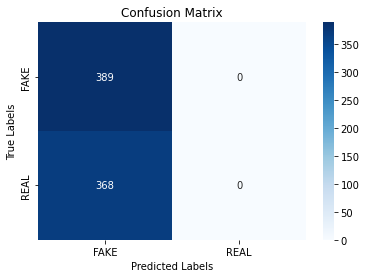

In [ ]:
# model evaluation

print("LaBSE, LSTM")
print("F-measure or f1-score: ", f1_score(y_valid, [math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))]))
print("Log loss: ", log_loss(y_valid, predictions_lstm))
print("Log loss: ", log_loss(y_valid, [math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))]))

fpr, tpr, thresholds = roc_curve(y_valid, predictions_lstm)

print("AUC: ", auc(fpr, tpr))

fpr, tpr, thresholds = roc_curve(y_valid,[math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))])

print("AUC: ", auc(fpr, tpr))

eval(y_valid, [math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))])

LSRM performed badly - it had propogated label "Fake" to every news.

LSTM architecture should be different.

## **Doc2Vec**

Application of the second representation approach.

In [ ]:
!pip install --upgrade numpy

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
import sys
import logging
import os
import gensim
from gensim.models import Doc2Vec
from nltk import sent_tokenize, word_tokenize

tagged_train_sent = []
count=0
for title in x_train:
    words = word_tokenize(title)
    tagged_train_sent.append(gensim.models.doc2vec.TaggedDocument(words, [0]))
    count+=1

tagged_test_sent = []
for title in x_test:
    words = word_tokenize(title)
    tagged_test_sent.append(gensim.models.doc2vec.TaggedDocument(words, [str(count)]))

model = Doc2Vec(tagged_train_sent, dm=1, size=100, window=8, min_count=5, workers=4)

In [ ]:
vector_size = 100

model_doc2vec = Doc2Vec(tagged_train_sent+tagged_test_sent, vector_size = vector_size, window = 4, min_count = 1, epochs = 100)

In [ ]:
x_train = data.loc[:,'title']
y_train = data.loc[:,'is_fake']
x_test = test_data.loc[:,'title']
y_test = test_data.loc[:,'is_fake']

In [ ]:
import tqdm

x_train_preprocessed = [model_doc2vec.infer_vector(word_tokenize(sent.lower())) for sent in tqdm.tqdm(x_train)]
x_test_preprocessed = [model_doc2vec.infer_vector(word_tokenize(sent.lower())) for sent in tqdm.tqdm(x_test)]

x_train_preprocessed_doc2vec = x_train_preprocessed
x_test_preprocessed_doc2vec = x_test_preprocessed

100%|██████████| 1000/1000 [00:04<00:00, 229.94it/s]


In [ ]:
import numpy as np

np.array(x_train_preprocessed).shape

(5758, 100)

In [ ]:
x_valid_preprocessed = x_train_preprocessed[5001:size]
x_train_preprocessed = x_train_preprocessed[0:5000]

y_valid = y_train[5001:size]
y_train = y_train[0:5000]

print(len(x_valid_preprocessed))
print(len(x_train_preprocessed))
print(len(y_valid))
print(len(y_train))

757
5000
757
5000


### **General classifier**

In [ ]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(np.array(x_train_preprocessed).reshape([len(x_train_preprocessed),vector_size]), np.array(x_valid_preprocessed).reshape([len(x_valid_preprocessed),vector_size]), y_train, y_valid)

print(models)

100%|██████████| 29/29 [00:42<00:00,  1.45s/it]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
SVC                                0.77               0.77     0.77      0.77   
NuSVC                              0.77               0.77     0.77      0.77   
XGBClassifier                      0.76               0.76     0.76      0.76   
LGBMClassifier                     0.76               0.76     0.76      0.76   
LogisticRegression                 0.75               0.75     0.75      0.75   
CalibratedClassifierCV             0.75               0.75     0.75      0.74   
LinearSVC                          0.74               0.74     0.74      0.74   
RandomForestClassifier             0.74               0.74     0.74      0.74   
RidgeClassifierCV                  0.74               0.74     0.74      0.74   
ExtraTreesClassifier               0.74               0.74     0.74      0.73   
RidgeClassifier             

In [ ]:
models = clf.provide_models(np.array(x_train_preprocessed).reshape([len(x_train_preprocessed),vector_size]), np.array(x_valid_preprocessed).reshape([len(x_valid_preprocessed),vector_size]), y_train, y_valid)
predictions = models['RandomForestClassifier'].predict(np.array(x_valid_preprocessed).reshape([len(x_valid_preprocessed),vector_size]))

print(sum([predictions[i] == np.array(y_valid)[i] for i in range(len(x_valid_preprocessed))]), len(x_valid_preprocessed))

562 757


BERT, best general classifier, no balancing techniques
F-measure or f1-score:  0.7389558232931726
AUC:  0.7433427405834357
Classification Report:
              precision    recall  f1-score   support

           1     0.7709    0.7095    0.7390       389
           0     0.7168    0.7772    0.7458       368

    accuracy                         0.7424       757
   macro avg     0.7439    0.7433    0.7424       757
weighted avg     0.7446    0.7424    0.7423       757



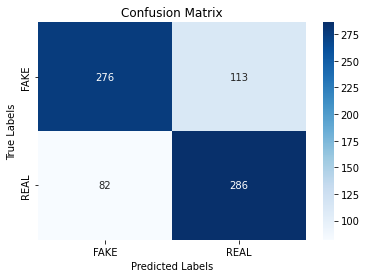

In [ ]:
# model evaluation
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns

print("Doc2vec, best general classifier")
print("F-measure or f1-score: ", f1_score(y_valid, predictions))
# print("Log loss: ", log_loss(y_test, predictions))

fpr, tpr, thresholds = roc_curve(y_valid, predictions)

print("AUC: ", auc(fpr, tpr))

eval(y_valid, predictions)

### **LSTM classifier**

In [ ]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from matplotlib import pyplot
from keras.layers import Bidirectional

In [ ]:
lstm = Sequential()
lstm.add(Bidirectional(LSTM(100, return_sequences=False)))
lstm.add(Dense(1, activation='sigmoid'))

callback = EarlyStopping(monitor='val_loss', patience=7)

lstm.compile(loss='binary_crossentropy', optimizer='adam')
lstm.fit(np.array(x_train_preprocessed).reshape([len(x_train_preprocessed),1,vector_size]), y_train, validation_data=(np.array(x_valid_preprocessed).reshape([len(x_valid_preprocessed),1,vector_size]), y_valid), epochs=50, batch_size=128, verbose=1, shuffle=True, callbacks=[callback])


Epoch 1/50
40/40 [==============================] - 6s 30ms/step - loss: 0.6387 - val_loss: 0.5797
Epoch 2/50
40/40 [==============================] - 0s 9ms/step - loss: 0.5669 - val_loss: 0.5341
Epoch 3/50
40/40 [==============================] - 0s 9ms/step - loss: 0.5429 - val_loss: 0.5243
Epoch 4/50
40/40 [==============================] - 0s 9ms/step - loss: 0.5376 - val_loss: 0.5181
Epoch 5/50
40/40 [==============================] - 0s 9ms/step - loss: 0.5356 - val_loss: 0.5191
Epoch 6/50
40/40 [==============================] - 0s 9ms/step - loss: 0.5368 - val_loss: 0.5210
Epoch 7/50
40/40 [==============================] - 0s 10ms/step - loss: 0.5358 - val_loss: 0.5139
Epoch 8/50
40/40 [==============================] - 0s 9ms/step - loss: 0.5266 - val_loss: 0.5223
Epoch 9/50
40/40 [==============================] - 0s 9ms/step - loss: 0.5265 - val_loss: 0.5111
Epoch 10/50
40/40 [==============================] - 0s 9ms/step - loss: 0.5236 - val_loss: 0.5102
Epoch 11/50
40/40

In [ ]:
import math

predictions_lstm = lstm.predict(np.array(x_valid_preprocessed).reshape([len(x_valid_preprocessed),1,vector_size]))

print(sum([math.ceil(predictions_lstm[i]) == np.array(y_valid)[i] for i in range(len(x_valid_preprocessed))]), len(x_valid_preprocessed))

389 757


Doc2Vec, LSTM
F-measure or f1-score:  0.6788830715532287
Log loss:  0.4902637394195419
Log loss:  16.790705370120794
AUC:  0.8415111210461608
AUC:  0.5
Classification Report:
              precision    recall  f1-score   support

           1     0.5139    1.0000    0.6789       389
           0     0.0000    0.0000    0.0000       368

    accuracy                         0.5139       757
   macro avg     0.2569    0.5000    0.3394       757
weighted avg     0.2641    0.5139    0.3489       757



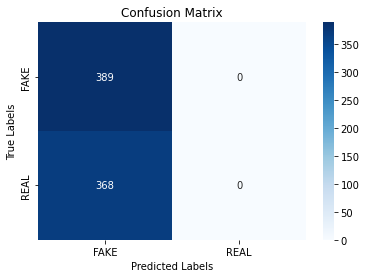

In [ ]:
# model evaluation
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns

print("Doc2Vec, LSTM")
print("F-measure or f1-score: ", f1_score(y_valid, [math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))]))
print("Log loss: ", log_loss(y_valid, predictions_lstm))
print("Log loss: ", log_loss(y_valid, [math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))]))

fpr, tpr, thresholds = roc_curve(y_valid, predictions_lstm)

print("AUC: ", auc(fpr, tpr))

fpr, tpr, thresholds = roc_curve(y_valid,[math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))])

print("AUC: ", auc(fpr, tpr))

eval(y_valid, [math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))])

Doc2vec does not implicitly states whether their pretrained model is applicable fot other languages apart from english.

The first and most probable reason of models weak performance might be due to inability to distinguish russian text. Therefore let's check it.

In [ ]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

sent_1 = "Зима лучшее время года"
sent_2 = "Люблю снег и холодную погоду"
sent_3 = "Астероид летит по космосу"

emb_sent_1 = model_doc2vec.infer_vector(word_tokenize(sent_1.lower()))
emb_sent_2 = model_doc2vec.infer_vector(word_tokenize(sent_2.lower()))
emb_sent_3 = model_doc2vec.infer_vector(word_tokenize(sent_3.lower()))

print(f'Cosine distance between similar sentances is {cosine(emb_sent_1, emb_sent_2)}')
print(f'Cosine distance between different sentances are {cosine(emb_sent_1, emb_sent_3)} and {cosine(emb_sent_2, emb_sent_3)}')

Cosine distance between similar sentances is 0.09384950250387192
Cosine distance between different sentances are -0.059831857681274414 and 0.5562050938606262


**Model is not applicable for Russian language**

## **sBert**

Application of the third representation approach.

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/sbert_large_mt_nlu_ru")
model = AutoModel.from_pretrained("sberbank-ai/sbert_large_mt_nlu_ru")

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

def sent_preprocess(sentence):
    encoded_input = tokenizer(sentence, padding=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**encoded_input)
    sentence_embedding = mean_pooling(model_output, encoded_input['attention_mask'])
    return np.array(sentence_embedding)

Downloading:   0%|          | 0.00/331 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/752 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.70M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.59G [00:00<?, ?B/s]

In [ ]:
x_train = data.loc[:,'title']
y_train = data.loc[:,'is_fake']
x_test = test_data.loc[:,'title']
y_test = test_data.loc[:,'is_fake']

In [ ]:
import tqdm
import numpy as np

x_train_preprocessed = [sent_preprocess(sent.lower()) for sent in tqdm.tqdm(x_train)]
x_test_preprocessed = [sent_preprocess(sent.lower()) for sent in tqdm.tqdm(x_test)]

x_train_preprocessed_sbert = x_train_preprocessed
x_test_preprocessed_sbert = x_test_preprocessed

100%|██████████| 1000/1000 [06:47<00:00,  2.46it/s]


In [ ]:
size = len(x_train)

x_valid_preprocessed = x_train_preprocessed[5001:size]
x_train_preprocessed = x_train_preprocessed[0:5000]

y_valid = y_train[5001:size]
y_train = y_train[0:5000]

print(len(x_valid_preprocessed))
print(len(x_train_preprocessed))
print(len(y_valid))
print(len(y_train))

757
5000
757
5000


### **General classifier**

In [ ]:
from lazypredict.Supervised import LazyClassifier

vector_size = 1024

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(np.array(x_train_preprocessed).reshape([len(x_train_preprocessed),vector_size]), np.array(x_valid_preprocessed).reshape([len(x_valid_preprocessed),vector_size]), y_train, y_valid)

print(models)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
100%|██████████| 29/29 [06:35<00:00, 13.63s/it]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
RidgeClassifierCV                  0.89               0.89     0.89      0.89   
SVC                                0.89               0.89     0.89      0.89   
RidgeClassifier                    0.89               0.89     0.89      0.89   
LinearDiscriminantAnalysis         0.88               0.88     0.88      0.88   
LogisticRegression                 0.88               0.88     0.88      0.88   
NuSVC                              0.88               0.88     0.88      0.88   
QuadraticDiscriminantAnalysis      0.87               0.87     0.87      0.87   
XGBClassifier                      0.87               0.87     0.87      0.87   
CalibratedClassifierCV             0.87               0.87     0.87      0.87   
LGBMClassifier                     0.87               0.87     0.87      0.87   
SGDClassifier               

In [ ]:
models = clf.provide_models(np.array(x_train_preprocessed).reshape([len(x_train_preprocessed),vector_size]), np.array(x_valid_preprocessed).reshape([len(x_valid_preprocessed),vector_size]), y_train, y_valid)
predictions = models['RidgeClassifierCV'].predict(np.array(x_valid_preprocessed).reshape([len(x_valid_preprocessed),vector_size]))

print(sum([predictions[i] == np.array(y_valid)[i] for i in range(len(x_valid_preprocessed))]), len(x_valid_preprocessed))

677 757


sBERT, best general classifier
F-measure or f1-score:  0.8947368421052632
AUC:  0.8948984296412206
Classification Report:
              precision    recall  f1-score   support

           1     0.9164    0.8740    0.8947       389
           0     0.8731    0.9158    0.8939       368

    accuracy                         0.8943       757
   macro avg     0.8947    0.8949    0.8943       757
weighted avg     0.8954    0.8943    0.8943       757



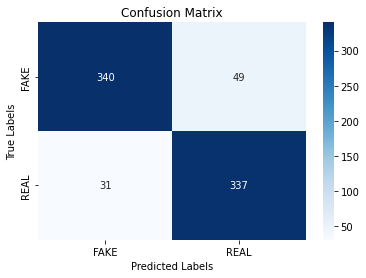

In [ ]:
# model evaluation
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns

print("sBERT, best general classifier")
print("F-measure or f1-score: ", f1_score(y_valid, predictions))
# print("Log loss: ", log_loss(y_test, predictions))

fpr, tpr, thresholds = roc_curve(y_valid, predictions)

print("AUC: ", auc(fpr, tpr))

eval(y_valid, predictions)

### **LSTM classifier**

In [ ]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from matplotlib import pyplot
from keras.layers import Bidirectional

In [ ]:
lstm = Sequential()
lstm.add(Bidirectional(LSTM(100, return_sequences=False)))
lstm.add(Dense(1, activation='sigmoid'))

callback = EarlyStopping(monitor='val_loss', patience=7)

lstm.compile(loss='binary_crossentropy', optimizer='adam')
lstm.fit(np.array(x_train_preprocessed).reshape([len(x_train_preprocessed),1,vector_size]), y_train, validation_data=(np.array(x_valid_preprocessed).reshape([len(x_valid_preprocessed),1,vector_size]), y_valid), epochs=50, batch_size=128, verbose=1, shuffle=True, callbacks=[callback])


Epoch 1/50
40/40 [==============================] - 7s 44ms/step - loss: 0.3723 - val_loss: 0.3003
Epoch 2/50
40/40 [==============================] - 1s 21ms/step - loss: 0.2631 - val_loss: 0.2822
Epoch 3/50
40/40 [==============================] - 1s 20ms/step - loss: 0.2279 - val_loss: 0.2647
Epoch 4/50
40/40 [==============================] - 1s 20ms/step - loss: 0.1924 - val_loss: 0.2664
Epoch 5/50
40/40 [==============================] - 1s 20ms/step - loss: 0.1667 - val_loss: 0.2803
Epoch 6/50
40/40 [==============================] - 1s 21ms/step - loss: 0.1364 - val_loss: 0.2868
Epoch 7/50
40/40 [==============================] - 1s 21ms/step - loss: 0.1290 - val_loss: 0.2662
Epoch 8/50
40/40 [==============================] - 1s 20ms/step - loss: 0.0842 - val_loss: 0.2937
Epoch 9/50
40/40 [==============================] - 1s 20ms/step - loss: 0.0646 - val_loss: 0.2832
Epoch 10/50
40/40 [==============================] - 1s 20ms/step - loss: 0.0506 - val_loss: 0.3051


In [ ]:
import math

predictions_lstm = lstm.predict(np.array(x_valid_preprocessed).reshape([len(x_valid_preprocessed),1,vector_size]))

print(sum([math.ceil(predictions_lstm[i]) == np.array(y_valid)[i] for i in range(len(x_valid_preprocessed))]), len(x_valid_preprocessed))

389 757


SBERT, LSTM
F-measure or f1-score:  0.6788830715532287
Log loss:  0.30510696953777494
Log loss:  16.790705370120794
AUC:  0.9586243992399688
AUC:  0.5
Classification Report:
              precision    recall  f1-score   support

           1     0.5139    1.0000    0.6789       389
           0     0.0000    0.0000    0.0000       368

    accuracy                         0.5139       757
   macro avg     0.2569    0.5000    0.3394       757
weighted avg     0.2641    0.5139    0.3489       757



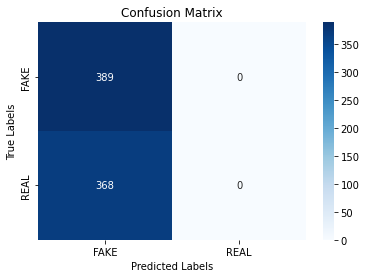

In [ ]:
# model evaluation
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns

print("SBERT, LSTM")
print("F-measure or f1-score: ", f1_score(y_valid, [math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))]))
print("Log loss: ", log_loss(y_valid, predictions_lstm))
print("Log loss: ", log_loss(y_valid, [math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))]))

fpr, tpr, thresholds = roc_curve(y_valid, predictions_lstm)

print("AUC: ", auc(fpr, tpr))

fpr, tpr, thresholds = roc_curve(y_valid,[math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))])

print("AUC: ", auc(fpr, tpr))

eval(y_valid, [math.ceil(predictions_lstm[i]) for i in range(len(predictions_lstm))])

Save results of sBert

In [ ]:
## save results of simple classifier trained on sBERT

outputs = test_data.copy()
SVC
predictions = models['RidgeClassifierCV'].predict(np.array(x_test_preprocessed).reshape([len(x_test_preprocessed),vector_size]))

outputs['is_fake'] = predictions

In [ ]:
outputs

,title,is_fake
0,Роскомнадзор представил реестр сочетаний цвето...,1
1,Ночью под Минском на президентской горе Белара...,1
2,Бывший спичрайтер Юрия Лозы рассказал о трудно...,1
3,"Сельская церковь, собравшая рекордно низкое ко...",1
4,Акции Google рухнули после объявления о переза...,0
...,...,...
995,Прокуратура заподозрила Явлинского в авторитар...,0
996,В День Победы стратегические ракетоносцы Ту-16...,1
997,СК возбудил дело против авиакомпании «Победа» ...,1
998,Криптомонетный двор Туркменистана выпустил юби...,1


In [ ]:
test_data

,title,is_fake
0,Роскомнадзор представил реестр сочетаний цвето...,0
1,Ночью под Минском на президентской горе Белара...,0
2,Бывший спичрайтер Юрия Лозы рассказал о трудно...,0
3,"Сельская церковь, собравшая рекордно низкое ко...",0
4,Акции Google рухнули после объявления о переза...,0
...,...,...
995,Прокуратура заподозрила Явлинского в авторитар...,0
996,В День Победы стратегические ракетоносцы Ту-16...,0
997,СК возбудил дело против авиакомпании «Победа» ...,0
998,Криптомонетный двор Туркменистана выпустил юби...,0


In [ ]:
outputs.to_csv("predictions.tsv", sep="\t", columns=['title', 'is_fake'], index=False)

Save results of LaBSE model

In [ ]:
## save results of simple classifier trained on LaBse

outputs = test_data.copy()
predictions = models['SVC'].predict(np.array(x_test_preprocessed).reshape([len(x_test_preprocessed),vector_size]))

outputs['is_fake'] = predictions

In [ ]:
outputs

,title,is_fake
0,Роскомнадзор представил реестр сочетаний цвето...,1
1,Ночью под Минском на президентской горе Белара...,1
2,Бывший спичрайтер Юрия Лозы рассказал о трудно...,1
3,"Сельская церковь, собравшая рекордно низкое ко...",1
4,Акции Google рухнули после объявления о переза...,0
...,...,...
995,Прокуратура заподозрила Явлинского в авторитар...,1
996,В День Победы стратегические ракетоносцы Ту-16...,1
997,СК возбудил дело против авиакомпании «Победа» ...,0
998,Криптомонетный двор Туркменистана выпустил юби...,1


In [ ]:
outputs.to_csv("predictions_labse.tsv", sep="\t", columns=['title', 'is_fake'], index=False)

# **Ways to improve the performance**

Generally, the choice of representation function (=embeddings) one of the most crutial. Here we used two strong models.

Good representation function might neglect bad fitting of classifier - because it sufficient replect all detected features.

But improvements might be done from the preprocessing stage.

1. 6% of non-russian words can be translated into russian. 
2. Digits might be written with words, not letters.
3. [generally, some stop words could be deleted, but in particular case these stop words do not have this prevailing spoiling role, because each news has considerably small amount of words]

**BUT** *Obtained **0.85-0.9** F1 score without normalization seems to be enough.*

[In case better performance is needed - better preprocessing could be applied]



---

Comparison of two predictions:

(just for interest)

In [ ]:
pred_labse = pd.read_csv("predictions_labse.tsv", sep="\t")
pred_sbert = pd.read_csv("predictions.tsv", sep="\t")

In [ ]:
print('% of mutually predicted titles is {0}'.format(sum(pred_labse['is_fake']==pred_sbert['is_fake'])/10))

% of mutually predicted titles is 87.1
